<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 (Chew En Zee, Jeral Fong Jian Yuan, Lee Yue Hang)

## Project Description

## Action Space

## State Space

|Num|Observation|Min|Max|
|---|-----------|---|---|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|~ -0.418 rad (-24°)|~ 0.418 rad (24°)|
|3|Pole Angular Velocity|-Inf|Inf|

## Conditions

The challenge is to balance the pole for 500 states per episode.

The pole is said to be balanced if:

- Pole Angle is at most ±12°
- Cart Position is at most ±2.4 (center of the cart reaches the edge of the display)

Violation to any of the above two conditions defines an unbalanced pole.

## Solution

## How does DQN work?

- Uses a neural network to estimate Q-values: it predicts the expected future reward for each possible action in a given state.
- Trains using past experiences stored in a replay buffer to break correlations and improve learning stability.
- Balances exploration and exploitation with an epsilon-greedy strategy and uses a separate target network to stabilize training.

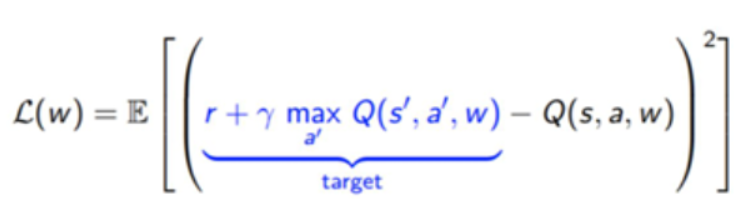

## Rationale

- DQN is effective for environments with discrete action spaces, like CartPole. Since the cart can only move left or right (two discrete actions), DQN is well-suited to learn the optimal action-value function through trial and error.
- DQN can handle continuous state spaces, as it uses a neural network to approximate Q-values instead of relying on a Q-table. This makes it ideal for the CartPole problem, where the observations (position, velocity, angle, angular velocity) are continuous.
- DQN is a value-based reinforcement learning algorithm, meaning it focuses on learning the optimal value function to guide decisions. This approach is powerful for relatively low-dimensional problems like CartPole, where learning from past experiences through replay buffers improves efficiency and stability.

## Installing dependencies:

In [35]:
!pip install gym tensorflow numpy matplotlib imageio

## Step 1: Imports and Setup

In [36]:
# Import libraries for the RL agent and visualization
import gym
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import HTML
import base64
import imageio

## Define the Q-Network

In [51]:
def create_q_network(state_dim, action_dim):
    """
    Creates a neural network to approximate Q-values for the DQN agent.
    
    Args:
        state_dim (int): Size of the state space (4 for CartPole).
        action_dim (int): Number of actions (2 for CartPole: left or right).
    
    Returns:
        tf.keras.Model: A neural network model for Q-value estimation.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(state_dim,), 
                              kernel_initializer='he_uniform'),  # Input layer
        tf.keras.layers.Dense(64, activation='relu', 
                              kernel_initializer='he_uniform'),  # Hidden layer
        tf.keras.layers.Dense(action_dim, activation='linear')           # Output layer
    ])
    return model

## Define the Replay Buffer

In [38]:
class ReplayBuffer:
    def __init__(self, capacity):
        """Initialize a replay buffer to store experiences."""
        self.buffer = deque(maxlen=capacity)  # Fixed-size buffer
    
    def push(self, state, action, reward, next_state, done):
        """Add an experience tuple to the buffer."""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Randomly sample a batch of experiences for training."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states, dtype=np.float32),
                np.array(actions, dtype=np.int32),
                np.array(rewards, dtype=np.float32),
                np.array(next_states, dtype=np.float32),
                np.array(dones, dtype=np.bool_))
    
    def __len__(self):
        """Return the current number of experiences in the buffer."""
        return len(self.buffer)

## Define the DQN Agent

In [39]:
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        """Initialize the DQN agent with Q-networks and hyperparameters."""
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = ReplayBuffer(100000)  # Large capacity for stability
        self.q_network = create_q_network(state_dim, action_dim)  # Main network
        self.target_network = create_q_network(state_dim, action_dim)  # Target network
        self.target_network.set_weights(self.q_network.get_weights())  # Sync initially
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Optimizer
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.1  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.gamma = 0.99  # Discount factor
        self.tau = 0.005  # Soft update factor
    
    def act(self, state, training=True):
        """Choose an action using an epsilon-greedy policy."""
        if training and random.random() < self.epsilon:  # Explore
            return random.randrange(self.action_dim)
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)  # Convert to tensor
        q_values = self.q_network(state_tensor)  # Predict Q-values
        return int(tf.argmax(q_values[0]).numpy())  # Exploit: pick action with max Q-value
    
    def update(self, batch_size):
        """Train the Q-network using a batch of experiences."""
        if len(self.replay_buffer) < batch_size:  # Wait until buffer has enough data
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        with tf.GradientTape() as tape:
            q_values = self.q_network(states)  # Current Q-value predictions
            q_values_selected = tf.reduce_sum(q_values * tf.one_hot(actions, self.action_dim), axis=1)
            
            # Double DQN: Use main network to select actions, target network to evaluate
            next_q_values = self.q_network(next_states)
            next_actions = tf.argmax(next_q_values, axis=1)
            target_q_values = self.target_network(next_states)
            max_next_q = tf.gather(target_q_values, next_actions, batch_dims=1)
            targets = rewards + self.gamma * max_next_q * (1.0 - tf.cast(dones, tf.float32))
            
            loss = tf.reduce_mean(tf.square(targets - q_values_selected))  # MSE loss
        
        gradients = tape.gradient(loss, self.q_network.trainable_variables)  # Compute gradients
        self.optimizer.apply_gradients(zip(gradients, self.q_network.trainable_variables))  # Update weights
        self.soft_update_target_network()  # Soft update target network
    
    def soft_update_target_network(self):
        """Gradually update the target network using a small tau value."""
        q_weights = self.q_network.get_weights()
        target_weights = self.target_network.get_weights()
        for i in range(len(q_weights)):
            target_weights[i] = (1 - self.tau) * target_weights[i] + self.tau * q_weights[i]
        self.target_network.set_weights(target_weights)
    
    def decay_epsilon(self):
        """Reduce epsilon to shift from exploration to exploitation."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## Training Loop

In [53]:
def train_dqn():
    """Train the DQN agent on CartPole-v1 and return the trained agent and environment."""
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]  # 4
    action_dim = env.action_space.n  # 2
    agent = DQNAgent(state_dim, action_dim)
    
    num_episodes = 500  # Train for 500 episodes
    batch_size = 128  # Batch size for training
    rewards_history = []  # Store rewards for plotting
    
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):  # Handle newer gym versions
            state = state[0]
        state = np.array(state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])  # Normalize
        total_reward = 0.0  # Initialize as float
        done = False
        
        while not done:
            action = agent.act(state)  # Choose action
            step_result = env.step(action)  # Take action
            if len(step_result) == 4:  # Older gym version
                next_state, reward, done, _ = step_result
            else:  # Newer gym version
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            next_state = np.array(next_state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])  # Normalize
            reward = float(reward)  # Ensure reward is a float
            agent.replay_buffer.push(state, action, reward, next_state, done)  # Store experience
            state = next_state
            total_reward += reward  # Accumulate reward
            agent.update(batch_size)  # Train the network
        
        agent.decay_epsilon()  # Reduce exploration
        rewards_history.append(total_reward)  # Store total reward for the episode
        
        # Compute running average for monitoring
        avg_reward = np.mean(rewards_history[-100:]) if len(rewards_history) >= 100 else np.mean(rewards_history)
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {total_reward}, Avg Reward (last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    # Debug: Check rewards_history for invalid values
    print("Training rewards:", rewards_history)
    
    # Ensure rewards_history contains only numeric values
    rewards_history = [float(r) for r in rewards_history]  # Convert to floats
    if not all(isinstance(r, (int, float)) for r in rewards_history):
        raise ValueError("rewards_history contains non-numeric values")
    
    # Plot training rewards
    plt.plot(range(len(rewards_history)), rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Training Progress')
    plt.show()
    
    return agent, env

# Train the agent
agent, env = train_dqn()

Episode 1/500, Reward: 31.0, Avg Reward (last 100): 31.00, Epsilon: 0.995
Episode 2/500, Reward: 12.0, Avg Reward (last 100): 21.50, Epsilon: 0.990
Episode 3/500, Reward: 12.0, Avg Reward (last 100): 18.33, Epsilon: 0.985
Episode 4/500, Reward: 17.0, Avg Reward (last 100): 18.00, Epsilon: 0.980
Episode 5/500, Reward: 31.0, Avg Reward (last 100): 20.60, Epsilon: 0.975
Episode 6/500, Reward: 46.0, Avg Reward (last 100): 24.83, Epsilon: 0.970
Episode 7/500, Reward: 10.0, Avg Reward (last 100): 22.71, Epsilon: 0.966
Episode 8/500, Reward: 20.0, Avg Reward (last 100): 22.38, Epsilon: 0.961
Episode 9/500, Reward: 14.0, Avg Reward (last 100): 21.44, Epsilon: 0.956
Episode 10/500, Reward: 12.0, Avg Reward (last 100): 20.50, Epsilon: 0.951
Episode 11/500, Reward: 14.0, Avg Reward (last 100): 19.91, Epsilon: 0.946
Episode 12/500, Reward: 13.0, Avg Reward (last 100): 19.33, Epsilon: 0.942
Episode 13/500, Reward: 12.0, Avg Reward (last 100): 18.77, Epsilon: 0.937
Episode 14/500, Reward: 37.0, Avg 

ValueError: object __array__ method not producing an array

<Figure size 640x480 with 1 Axes>

## Task 1: Demonstrate Agent Action Selection

### Objective
Sample a random state from the CartPole environment, input it to the trained agent, and output the chosen action.

### Approach
- Sample a random state from the environment's observation space.
- Normalize the state to match training conditions.
- Use the trained agent's greedy policy (training=False) to select an action.
- Print the state and action for verification.

In [55]:
# Sample a random state and get the agent's action
random_state = env.observation_space.sample()  # Random state from CartPole
random_state = np.array(random_state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])  # Normalize
action = agent.act(random_state, training=False)  # Greedy action selection

print("Random State (normalized):", random_state)
print("Chosen Action:", action)

Random State (normalized): [-6.31010036e-01  1.14657400e+36 -6.30370524e-01  5.85730799e+37]
Chosen Action: 0


## Task 2: Evaluate Agent Effectiveness

### Objective
Run the agent for 100 episodes, plot cumulative rewards, and ensure the average reward exceeds 195.

### Approach
- Run 100 evaluation episodes with the greedy policy.
- Record and plot the cumulative reward per episode.
- Compute and print the average reward.

In [56]:
def evaluate_agent(agent, env, num_episodes=100):
    """Evaluate the trained agent over multiple episodes."""
    eval_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        state = np.array(state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])  # Normalize
        total_reward = 0.0  # Initialize as float
        done = False
        while not done:
            action = agent.act(state, training=False)  # Greedy policy
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            next_state = np.array(next_state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])
            reward = float(reward)  # Ensure reward is a float
            total_reward += reward  # Accumulate reward
            state = next_state
        eval_rewards.append(total_reward)
    
    # Debug: Print eval_rewards to check for invalid values
    print("Evaluation rewards:", eval_rewards)
    
    # Ensure eval_rewards contains only numeric values
    eval_rewards = [float(r) for r in eval_rewards]  # Convert to floats
    if not all(isinstance(r, (int, float)) for r in eval_rewards):
        raise ValueError("eval_rewards contains non-numeric values")
    
    # Plot evaluation rewards
    plt.plot(range(len(eval_rewards)), eval_rewards)
    plt.title('Cumulative reward for each episode')
    plt.ylabel('Cumulative reward')
    plt.xlabel('Episode')  # Added for clarity
    plt.show()
    
    # Compute and print average reward in the specified format
    avg_reward = np.mean(eval_rewards)
    print(f"Average cumulative reward: {avg_reward:.2f}")
    print(f"Is my agent good enough? {avg_reward > 195}")

# Run evaluation
evaluate_agent(agent, env)

Evaluation rewards: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


ValueError: object __array__ method not producing an array

<Figure size 640x480 with 1 Axes>

Average cumulative reward: 500.00
Is my agent good enough? True


## Task 3: Render One Episode

### Objective
Render a single episode played by the agent as a video in the notebook.

### Approach
- Create an environment with 'rgb_array' mode for frame capture.
- Run one episode, collecting frames.
- Convert frames into a video and display it using HTML.

In [61]:
import gym
import pygame
import time
import numpy as np

def render_episode(agent, env):
    """
    Render one episode of the CartPole environment using Pygame.
    
    Args:
        agent: The trained RL agent (e.g., DQNAgent) with an `act` method.
        env: The CartPole environment instance (unused here, recreated with 'human' mode).
    """
    # Create a new environment instance with 'human' render mode for Pygame
    env = gym.make('CartPole-v1', render_mode='human')
    
    # Reset the environment to start a new episode
    state = env.reset()
    if isinstance(state, tuple):  # Handle newer gym versions returning tuples
        state = state[0]
    # Normalize the state to match training conditions
    state = np.array(state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])
    
    done = False
    total_reward = 0.0
    
    # Initialize Pygame
    pygame.init()
    
    # Run one episode
    while not done:
        # Select action using the agent's greedy policy
        action = agent.act(state, training=False)
        
        # Perform the action in the environment
        step_result = env.step(action)
        if len(step_result) == 4:  # Older gym versions
            next_state, reward, done, _ = step_result
        else:  # Newer gym versions with terminated/truncated
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        
        # Update state and accumulate reward
        next_state = np.array(next_state, dtype=np.float32) / np.array([4.8, 10.0, 0.418, 5.0])
        state = next_state
        total_reward += reward
        
        # Render the current frame
        env.render()
        
        # Add a delay to control rendering speed (adjustable)
        time.sleep(0.02)
    
    # Cleanup: close the environment and Pygame
    env.close()
    pygame.quit()
    
    # Display the total reward for the episode
    print(f"Episode completed with total reward: {total_reward}")


render_episode(agent, env)

Episode completed with total reward: 500.0
